In [2]:
import scanpy as sc
import anndata
import numpy as np
import seaborn as sns
from matplotlib.pyplot import rc_context
import matplotlib.pyplot as plt
import tifffile
import skimage.io as io

import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, AgglomerativeClustering

from tqdm import tqdm
import pickle
import os

In [2]:
adata = anndata.read_h5ad(filename=r'..\..\20210507_cytokines\uc\subcellular_neirhborhood\exp2_uc_017_1 clustered data.h5ad')

In [3]:
adata.obs['leiden']

0        37
1        38
2        38
3        38
4        38
         ..
12107    45
12108    32
12109    32
12110    54
12111    43
Name: leiden, Length: 12112, dtype: category
Categories (57, object): ['0', '1', '2', '3', ..., '53', '54', '55', '56']

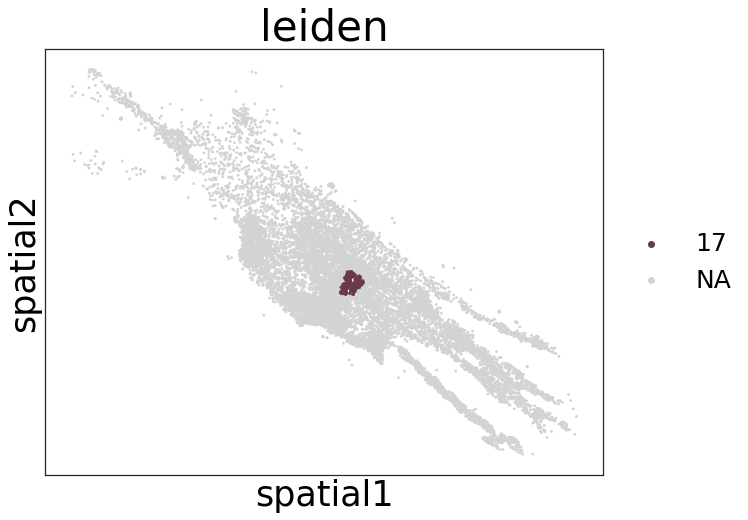

In [4]:
# for i in range(41):
with rc_context({'figure.figsize': (10, 10), 'font.size': 35, 'axes.edgecolor': '0.15', 
                 'axes.linewidth': 1.25, 'axes.facecolor': '#FFFFFF', 'savefig.dpi': 600}):
    sc.pl.spatial(adata, color="leiden", groups=['17'], spot_size=10, legend_fontsize=25,
                 save='bmes_uc_017_17.png')
    # , save='hch_005_8 patch '+str(i)+'.png'

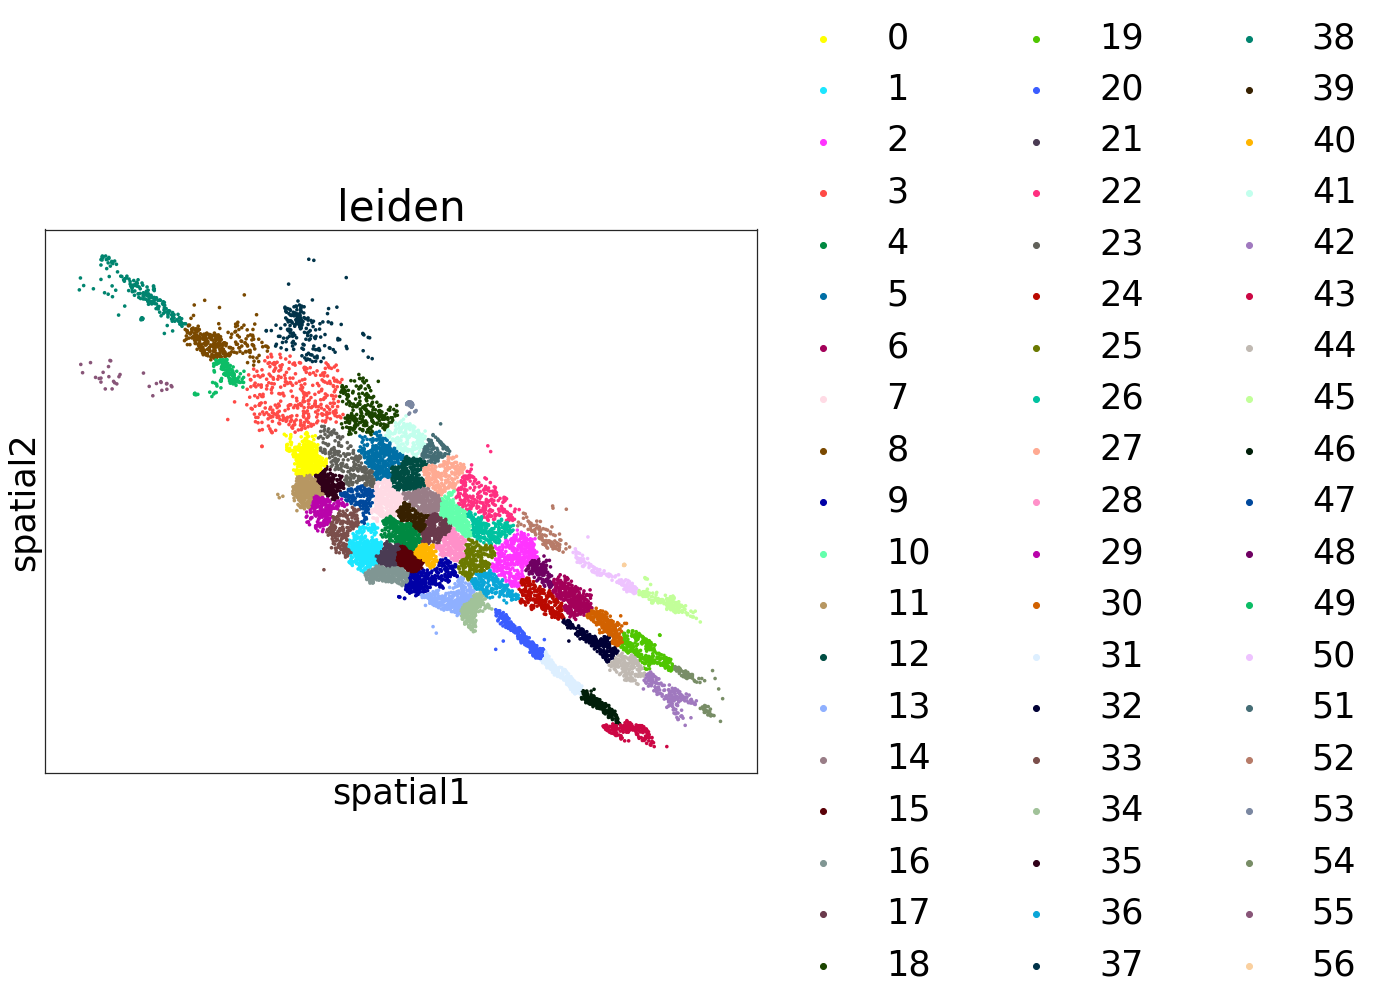

In [5]:
with rc_context({'figure.figsize': (15, 10), 'font.size': 35, 'axes.edgecolor': '0.15',
                 'axes.linewidth': 1.25, 'axes.facecolor': '#FFFFFF', 'savefig.dpi': 600}):
    sc.pl.spatial(adata, color="leiden", spot_size=10, legend_fontsize=35, save=' BMES uc_017.png')

In [6]:
# Load dot locations
fn = r'Y:\\coskun-lab\\Zhou\\4_HCR\\20210507_cytokines\\uc\\00_registered_images\\detected_dot_positions\\exp2_uc_017_1.pkl'
cell = pd.read_pickle(fn)

In [7]:
neighborhood = adata.obs['leiden'].tolist()
neighborhood = [int(item) for item in neighborhood]

In [8]:
new_dic = {}
for k in cell.keys():
    df = pd.DataFrame(cell[k])
    df.columns = ['row', 'column']
    df['cluster'] = neighborhood[:df.shape[0]]
    neighborhood = neighborhood[df.shape[0]:]
    new_dic[k] = df

In [9]:
df = None
for k in new_dic.keys():
    if df is None:
        t = new_dic[k]
        t['gene'] = [k]*t.shape[0]
        df = t
    else:
        t = new_dic[k]
        t['gene'] = [k]*t.shape[0]
        df = pd.concat([df, t])

In [10]:
df

,row,column,cluster,gene
0,147,714,37,IL8
1,218,269,38,IL8
2,220,269,38,IL8
3,226,271,38,IL8
4,228,269,38,IL8
...,...,...,...,...
32,1032,1640,45,NANOG
33,1199,1498,32,NANOG
34,1204,1422,32,NANOG
35,1306,1747,54,NANOG


In [14]:
n_clusters = len(np.unique(adata.obs['leiden'].tolist()))
rna_neighbor_exp = np.zeros((n_clusters, 16))
genes = []
i = 0
markers_l = []
for k in new_dic.keys():
    genes.append(k)
    for j in range(n_clusters):
         rna_neighbor_exp[j,i] = sum(item==j for item in new_dic[k]['cluster'].tolist())
    i = i + 1

In [15]:
def proximity_network(cluster_rna_df, n_neighbors):
    r = cluster_rna_df['row'].tolist()
    c = cluster_rna_df['column'].tolist()
    r_c = list(zip(r,c))
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    neigh.fit(r_c)
    dist, neighbors = neigh.kneighbors(r_c)
    
    genes = cluster_rna_df['gene'].tolist()
    markers_l = list(np.unique(genes))
    counts = np.zeros((cluster_rna_df.shape[0], len(markers_l)))
    for i in range(neighbors.shape[0]):
        for j in range(neighbors.shape[1]):
            neighbor = neighbors[i,j]
            idx = markers_l.index(genes[neighbor])
            counts[i,idx] = counts[i,idx] + 1
    df = pd.DataFrame(counts, columns=markers_l)
    return df.corr(method='pearson')

In [16]:
corr_l = []
for i in range(n_clusters-1):
    corr_l.append(proximity_network(df.loc[df['cluster']==i], n_neighbors=10))

In [17]:
df.loc[df['cluster']==i]

,row,column,cluster,gene
8,460,241,55,IL8
5,436,67,55,CCL11
7,459,72,55,CCL11
8,504,154,55,CCL11
347,458,129,55,ACTB
369,470,145,55,ACTB
373,474,123,55,ACTB
392,483,158,55,ACTB
409,490,305,55,ACTB
432,504,135,55,ACTB


In [18]:
# out_dir = r'Y:\\coskun-lab\\Zhou\\4_HCR\\20210507_cytokines\\uc\\subcellular proximity\\exp2_017_1_57_neighborhoods_10_neighbors\\56_clusters'

In [19]:
# with open(os.path.join(out_dir, 'uc_017_1_56_neighborhoods_10_neighbors.pkl'), 'wb') as f:
#     pickle.dump(corr_l, f)

In [20]:
temp = df.loc[df['cluster']==10]

In [21]:
r = temp['row'].tolist()
c = temp['column'].tolist()

In [22]:
r_c = list(zip(r,c))
neigh = NearestNeighbors(n_neighbors=10)
neigh.fit(r_c)
dist, neighbors = neigh.kneighbors(r_c)

In [23]:
temp = pd.read_pickle(r'Y:\\coskun-lab\\Zhou\\4_HCR\\20210507_cytokines\\uc\\subcellular proximity\\exp2_017_1_57_neighborhoods_10_neighbors\\56_clusters\\uc_017_1_56_neighborhoods_10_neighbors.pkl')

In [24]:
corr = temp[0]

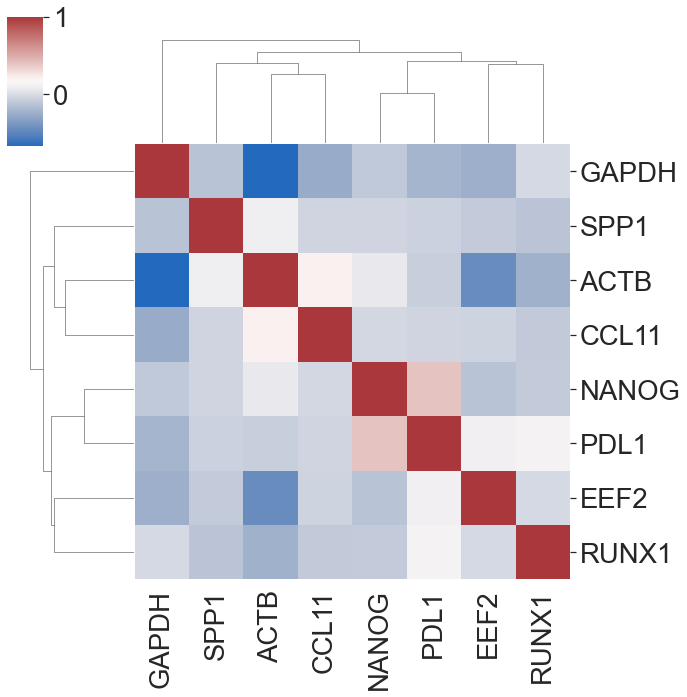

In [25]:
sns.set(font_scale=2.5)
sns.clustermap(corr, cmap='vlag')
# plt.savefig(r'.\\figures\\exp2_uc_017_1_correlation.png')

# Visualize nearet neighbor

In [26]:
adata

AnnData object with n_obs × n_vars = 12112 × 2
    obs: 'leiden'
    uns: 'leiden', 'neighbors', 'leiden_colors'
    obsm: 'spatial'
    obsp: 'connectivities', 'distances'

In [27]:
patches = adata.obs['leiden'].tolist()
colors = adata.uns['leiden_colors']
points = adata.X
dot_colors = adata.uns['leiden_colors']

In [28]:
points.shape

(12112, 2)

In [43]:
patch_df = df.loc[df['cluster']==17]

In [44]:
patch_df

,row,column,cluster,gene
24,888,1042,17,CCL11
8,857,1039,17,SOX9
11,906,1027,17,SOX9
12,913,1032,17,SOX9
374,853,1051,17,COL1A1
...,...,...,...,...
1861,922,1049,17,GAPDH
1872,925,1060,17,GAPDH
1883,928,1032,17,GAPDH
1890,929,1035,17,GAPDH


In [45]:
r = patch_df['row'].tolist()
c = patch_df['column'].tolist()
r_c = list(zip(r,c))

In [46]:
m = np.mean(r_c, axis=0).reshape(1,2)
neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(r_c)
dist, neighbors = neigh.kneighbors(m)

In [47]:
neighbors

array([[109]], dtype=int64)

In [56]:
c = r_c[109]
c = np.array(c).reshape(1,2)

In [57]:
neigh = NearestNeighbors(n_neighbors=10)
neigh.fit(r_c)
dist, neighbors = neigh.kneighbors(c)

In [58]:
patch_df

,row,column,cluster,gene
24,888,1042,17,CCL11
8,857,1039,17,SOX9
11,906,1027,17,SOX9
12,913,1032,17,SOX9
374,853,1051,17,COL1A1
...,...,...,...,...
1861,922,1049,17,GAPDH
1872,925,1060,17,GAPDH
1883,928,1032,17,GAPDH
1890,929,1035,17,GAPDH


In [59]:
gene_color_dict = {'GAPDH': '#ffffff',
                   'ACTB': '#c34fff',
                   'IL8': '01a5ca',
                   'IL6': '#ec9d00',
                   'CCL11': '#ff7598',
                   'COL1A1': '#a6a19a',
                   'SPP1': '#edb7ff',
                   'SOX9': '#fff585',
                   'EEF2': '#92b853',
                   'NANOG': '#abd4ff',
                   'RUNX1': '#ff5401',
                   'PDL1': '#ffc3a6'
                  }

In [60]:
raw_im = tifffile.imread(r'Y:\\coskun-lab\\Zhou\\4_HCR\\20210507_cytokines\\uc\\00_registered_images\\figures\\017\\adjusted\\00_nucleus_hch_017.tif')

In [61]:
for i in range(10):
    print(patch_df.iloc[neighbors[0,i]])

row         893
column     1051
cluster      17
gene       ACTB
Name: 2499, dtype: object
row           893
column       1048
cluster        17
gene       COL1A1
Name: 498, dtype: object
row          895
column      1054
cluster       17
gene       RUNX1
Name: 343, dtype: object
row         889
column     1048
cluster      17
gene       ACTB
Name: 2464, dtype: object
row         894
column     1046
cluster      17
gene       ACTB
Name: 2504, dtype: object
row           897
column       1047
cluster        17
gene       COL1A1
Name: 510, dtype: object
row           897
column       1056
cluster        17
gene       COL1A1
Name: 511, dtype: object
row          897
column      1056
cluster       17
gene       GAPDH
Name: 1749, dtype: object
row         893
column     1058
cluster      17
gene       ACTB
Name: 2500, dtype: object
row         888
column     1045
cluster      17
gene       ACTB
Name: 2457, dtype: object


In [62]:
sub_df

,row,column,cluster,gene
37,910,1027,17,PDL1
38,914,1053,17,PDL1


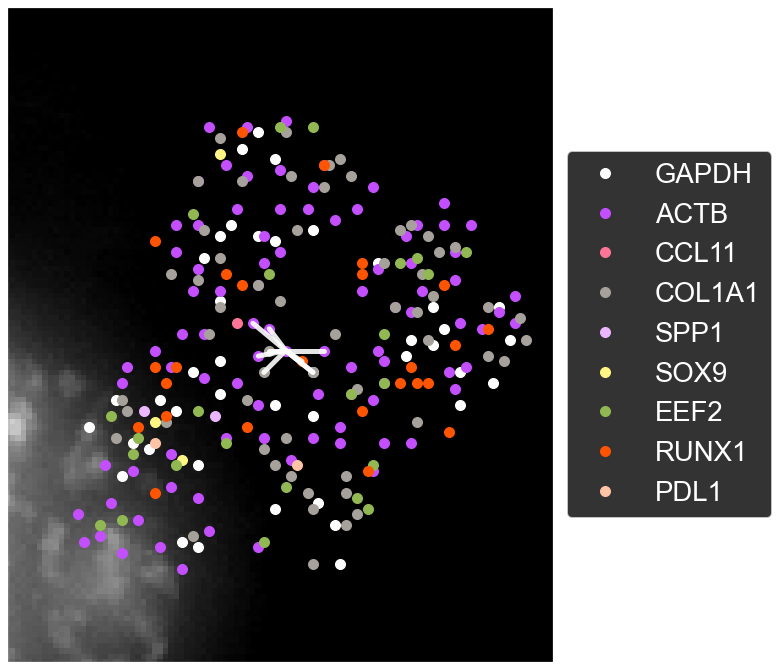

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
ax.imshow(raw_im, cmap=plt.cm.gray)
ax.grid(False)
# ax.plot(l[:,1]-1000, l[:,0]-840, 'ro')

legends = []
for k in gene_color_dict.keys():
    color = gene_color_dict[k]
    if k in patch_df['gene'].tolist():
        sub_df = patch_df.loc[patch_df['gene']==k]
        ax.plot(sub_df['column'].values, sub_df['row'].values, 'o', markersize=10, color=color, label=k)
        legends.append(k)

for i in range(neighbors.shape[1]-1):
    point0 = r_c[neighbors[0,0]]
    point1 = r_c[neighbors[0,i+1]]
    ax.plot([point0[1],point1[1]], [point0[0],point1[0]], 'w-', linewidth=5, alpha=0.9)

ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([])
ax.set_xlim(xmin=1000,xmax=1100)
ax.set_ylim(ymin=950, ymax=830)
legend = ax.legend(loc=0, bbox_to_anchor=(1,0.8), ncol=1)
frame = legend.get_frame()
frame.set_facecolor('black')
text = legend.get_texts()
for l in text:
    l.set_color('white')
plt.tight_layout()
# plt.savefig('BMES col-pos nearest neighbor visual legend.png', dpi=600)
plt.show()

# Batch Network Inference

In [65]:
cluster_dir = r'Y:\\coskun-lab\\Zhou\\4_HCR\\20210507_cytokines\\uc\\subcellular_neirhborhood'
dot_dir = r'Y:\\coskun-lab\\Zhou\\4_HCR\\20210507_cytokines\\uc\\00_registered_images\\detected_dot_positions'
out_dir = r'Y:\\coskun-lab\\Zhou\\4_HCR\\20210507_cytokines\\uc\\subcellular_network_batch'
fn_l = os.listdir(cluster_dir)
fn_l.sort()
fn_l2 = os.listdir(dot_dir)
fn_l2.sort()

In [66]:
n_markers_hch = 16
n_markers_msc = 12 

In [67]:
for fn in tqdm(fn_l):
    adata = None
    if fn.endswith('.h5ad'):
        adata = anndata.read_h5ad(filename=os.path.join(cluster_dir, fn))
        name = fn.split(' ')[0]
        cell = pd.read_pickle(os.path.join(dot_dir, name+'.pkl'))
    else:
        continue
    neighborhood = adata.obs['leiden'].tolist()
    neighborhood = [int(item) for item in neighborhood]
    new_dic = {}
    for k in cell.keys():
        df = pd.DataFrame(cell[k])
        if len(cell[k]) == 0:
            continue
        df.columns = ['row', 'column']
        df['cluster'] = neighborhood[:df.shape[0]]
        neighborhood = neighborhood[df.shape[0]:]
        new_dic[k] = df
    
    df = None
    for k in new_dic.keys():
        if df is None:
            t = new_dic[k]
            t['gene'] = [k]*t.shape[0]
            df = t
        else:
            t = new_dic[k]
            t['gene'] = [k]*t.shape[0]
            df = pd.concat([df, t])
            
    n_clusters = len(np.unique(adata.obs['leiden'].tolist()))
    rna_neighbor_exp = np.zeros((n_clusters, n_markers_msc))
    genes = []
    i = 0
    markers_l = []
    for k in new_dic.keys():
        genes.append(k)
        for j in range(n_clusters):
             rna_neighbor_exp[j,i] = sum(item==j for item in new_dic[k]['cluster'].tolist())
        i = i + 1
    corr_l = []
    for i in range(n_clusters-1):
        if df.loc[df['cluster']==i].shape[0]<10:
            continue
        corr_l.append(proximity_network(df.loc[df['cluster']==i], n_neighbors=10))
    with open(os.path.join(out_dir, name+' neighborhoods_10_neighbors.pkl'), 'wb') as f:
        pickle.dump(corr_l, f)

100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [00:13<00:00,  8.73it/s]


# Patch z-score

In [117]:
cluster_dir = r'Y:\\coskun-lab\\Zhou\\4_HCR\\20210614_hchCulture\\subcellular_neighborhoods'
out_dir = r'Y:\\coskun-lab\\Zhou\\4_HCR\\20210614_hchCulture\\subcellular_network_batch\\z_score'
fn_l = os.listdir(cluster_dir)
fn_l.sort()

In [118]:
for fn in fn_l:
    if fn.endswith('.pkl'):
        cell_id = fn.split(' ')[0]
        patch_expression = pd.read_pickle(os.path.join(cluster_dir, fn))['expression']
        z_score = (patch_expression-patch_expression.mean())/patch_expression.std()
        with open(os.path.join(out_dir, cell_id+' patch_z-score.pkl'), 'wb') as f:
            pickle.dump(z_score, f)

# Subcellular Network Variance

In [11]:
bm_in_dir = r'Y:\\coskun-lab\\Zhou\\4_HCR\\20210324_11gene\\BM\\registered images\\subcellular_network_batch'
uc_in_dir1 = r'Y:\\coskun-lab\\Zhou\\4_HCR\\20210324_11gene\\UC\\00_registered_images\\subcellular_network_batch'
uc_in_dir2 = r'Y:\\coskun-lab\\Zhou\\4_HCR\\20210507_cytokines\\uc\\subcellular_network_batch'
hch_in_dir = r'Y:\\coskun-lab\\Zhou\\4_HCR\\20210614_hchCulture\\subcellular_network_batch'

In [25]:
markers = ['GAPDH','ACTB','IL8','IL6','CCL11','SOX9','RUNX1','SPP1','EEF2','PDL1','COL1A1','NANOG']
pairs = []

for i in range(len(markers)):
    for j in range(len(markers)):
        if markers[i]!=markers[j] and (not ((markers[i]+'_'+markers[j] in pairs) or (markers[j]+'_'+markers[i] in pairs))):
            pairs.append(markers[i]+'_'+markers[j])

In [26]:
fn_l = os.listdir(bm_in_dir)
fn_l.sort()

In [29]:
fn = fn_l[0]
l = pd.read_pickle(os.path.join(bm_in_dir, fn))
len(l)
temp = []
mean = np.zeros(len(pairs))
std = np.zeros(len(pairs))
for j in range(len(pairs)):
    gene1,gene2 = pairs[j].split('_')
    temp.append([])
    for i in range(len(l)):
        if (gene1 in l[i].columns.tolist()) and (gene2 in l[i].columns.tolist()):
            temp[j].append(l[i].loc[gene1,gene2])
    # print(pairs[j]+' interactions: '+str(len(temp[j]))+' Mean interaction: '+str(np.mean(np.array(temp[j])))+'Std interaction: '+str(np.std(np.array(temp[j]))))
    mean[j] = np.mean(np.array(temp[j]))
    std[j] = np.std(np.array(temp[j]))
# print(np.mean(temp, axis=0).shape)
# print(np.std(temp, axis=0).shape)
# m = np.mean(temp, axis=0)
# s = np.std(temp, axis=0)
# print(np.concatenate((m,s)).shape)

GAPDH_ACTB interactions: 44 Mean interaction: -0.19143909756596053Std interaction: 0.3285884668629548
GAPDH_IL8 interactions: 7 Mean interaction: 0.09384058658719878Std interaction: 0.24459112828227753
GAPDH_IL6 interactions: 37 Mean interaction: -0.10431284188106525Std interaction: 0.23129971973108746
GAPDH_CCL11 interactions: 8 Mean interaction: -0.13065448008633296Std interaction: 0.2753286459252126
GAPDH_SOX9 interactions: 18 Mean interaction: -0.09014791705758267Std interaction: 0.2248795004087054
GAPDH_RUNX1 interactions: 28 Mean interaction: -0.10631573911336348Std interaction: 0.28083058264924543
GAPDH_SPP1 interactions: 16 Mean interaction: -0.12492713862315549Std interaction: 0.19670767640185638
GAPDH_EEF2 interactions: 44 Mean interaction: -0.28988864832007427Std interaction: 0.26131388327727806
GAPDH_PDL1 interactions: 3 Mean interaction: -0.13990312581104528Std interaction: 0.14635933791094943
GAPDH_COL1A1 interactions: 38 Mean interaction: -0.3774631891218087Std interacti

C:\Users\zfang38\Anaconda3\envs\scenv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\zfang38\Anaconda3\envs\scenv\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\zfang38\Anaconda3\envs\scenv\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\Users\zfang38\Anaconda3\envs\scenv\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
C:\Users\zfang38\Anaconda3\envs\scenv\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [82]:
t = l[0]

In [34]:
fn_l = os.listdir(bm_in_dir)
bm_cell_id = []
bm_arr = []
for fn in tqdm(fn_l):
    bm_cell_id.append(fn.split(' ')[0])
    l = pd.read_pickle(os.path.join(bm_in_dir, fn))
    temp = []
    m = np.zeros(len(pairs))
    s = np.zeros(len(pairs))
    for j in range(len(pairs)):
        gene1,gene2 = pairs[j].split('_')
        temp.append([])
        for i in range(len(l)):
            if (gene1 in l[i].columns.tolist()) and (gene2 in l[i].columns.tolist()):
                temp[j].append(l[i].loc[gene1,gene2])
        if len(temp[j])!=0:
            m[j] = np.mean(np.array(temp[j]))
            s[j] = np.std(np.array(temp[j]))
    bm_arr.append(np.concatenate((m,s)))

100%|████████████████████████████████████████████████████████████████████████████████| 237/237 [00:07<00:00, 33.55it/s]


In [35]:
fn_l = os.listdir(uc_in_dir1)
exp1_uc_cell_id = []
uc_arr = []
for fn in tqdm(fn_l):
    exp1_uc_cell_id.append(fn.split(' ')[0])
    l = pd.read_pickle(os.path.join(uc_in_dir1, fn))
    temp = []
    m = np.zeros(len(pairs))
    s = np.zeros(len(pairs))
    for j in range(len(pairs)):
        gene1,gene2 = pairs[j].split('_')
        temp.append([])
        for i in range(len(l)):
            if (gene1 in l[i].columns.tolist()) and (gene2 in l[i].columns.tolist()):
                temp[j].append(l[i].loc[gene1,gene2])
        if len(temp[j])!=0:
            m[j] = np.mean(np.array(temp[j]))
            s[j] = np.std(np.array(temp[j]))
    uc_arr.append(np.concatenate((m,s)))

100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [00:04<00:00, 18.35it/s]


In [36]:
fn_l = os.listdir(uc_in_dir2)
exp2_uc_cell_id = []
for fn in tqdm(fn_l):
    exp2_uc_cell_id.append(fn.split(' ')[0])
    l = pd.read_pickle(os.path.join(uc_in_dir2, fn))
    temp = []
    m = np.zeros(len(pairs))
    s = np.zeros(len(pairs))
    for j in range(len(pairs)):
        gene1,gene2 = pairs[j].split('_')
        temp.append([])
        for i in range(len(l)):
            if (gene1 in l[i].columns.tolist()) and (gene2 in l[i].columns.tolist()):
                temp[j].append(l[i].loc[gene1,gene2])
        if len(temp[j])!=0:
            m[j] = np.mean(np.array(temp[j]))
            s[j] = np.std(np.array(temp[j]))
    uc_arr.append(np.concatenate((m,s)))

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.40it/s]


In [37]:
fn_l = os.listdir(hch_in_dir)
hch_cell_id = []
hch_arr = []
for fn in tqdm(fn_l):
    hch_cell_id.append(fn.split(' ')[0])
    l = pd.read_pickle(os.path.join(hch_in_dir, fn))
    temp = []
    m = np.zeros(len(pairs))
    s = np.zeros(len(pairs))
    for j in range(len(pairs)):
        gene1,gene2 = pairs[j].split('_')
        temp.append([])
        for i in range(len(l)):
            if (gene1 in l[i].columns.tolist()) and (gene2 in l[i].columns.tolist()):
                temp[j].append(l[i].loc[gene1,gene2])
        if len(temp[j])!=0:
            m[j] = np.mean(np.array(temp[j]))
            s[j] = np.std(np.array(temp[j]))
    hch_arr.append(np.concatenate((m,s)))

100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:12<00:00, 19.66it/s]


In [67]:
bm_arr = np.array(bm_arr)
bm_arr = np.nan_to_num(bm_arr)
uc_arr = np.array(uc_arr)
hch_arr = np.array(hch_arr)

In [77]:
print('Number of bm cells: '+str(bm_arr.shape[0]))
print('Number of uc cells: '+str(uc_arr.shape[0]))
print('Number of hch cells: '+str(hch_arr.shape[0]))

Number of bm cells: 237
Number of uc cells: 121
Number of hch cells: 247


In [69]:
var_names = []
for item in pairs:
    var_names.append('mean_'+item)
for item in pairs:
    var_names.append('std_'+item)

In [70]:
cell_types = pd.Categorical(['HBM']*bm_arr.shape[0] + ['HUC']*uc_arr.shape[0] + ['HCH']*hch_arr.shape[0],ordered=True, categories=['HBM','HUC','HCH'])

In [71]:
var_adata = sc.AnnData(np.concatenate((bm_arr, uc_arr, hch_arr)))
var_adata.obs['Cell'] = bm_cell_id+exp1_uc_cell_id+exp2_uc_cell_id+hch_cell_id 
var_adata.var_names = var_names
var_adata.obs['cell_types'] = cell_types
var_adata.uns['cell_types_colors'] = ['#0000ff', '#ff0000', '#00ac00']

In [72]:
sc.pp.pca(var_adata)

In [81]:
sc.pp.neighbors(var_adata)
sc.tl.umap(var_adata)
sc.tl.leiden(var_adata, resolution=1)

In [82]:
var_adata

AnnData object with n_obs × n_vars = 605 × 132
    obs: 'Cell', 'cell_types', 'leiden'
    uns: 'cell_types_colors', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [2]:
# Load h5ad file if already exists
var_adata = sc.read_h5ad(filename='.\\clustering of network variability.h5ad')

In [14]:
sc.tl.leiden(var_adata, resolution=0.25)

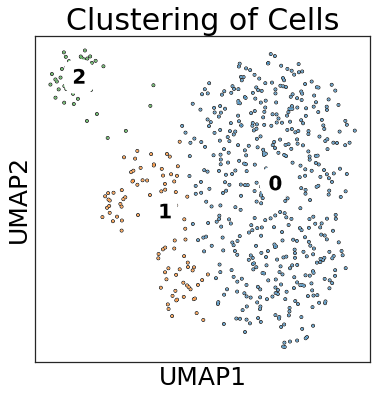

In [16]:
with rc_context({'figure.figsize': (6, 6), 'font.size':25, 'axes.edgecolor': '0.15', 'axes.linewidth': 1.25, 'axes.facecolor':'#FFFFFF'}):
    sc.pl.umap(var_adata, color=['leiden'], size=20, 
               add_outline=True, legend_loc='on data',
               legend_fontsize=20, legend_fontoutline=20, 
               frameon=True,  title='Clustering of Cells'
               , save=' network mean and variance clustering 3 clusters.png')

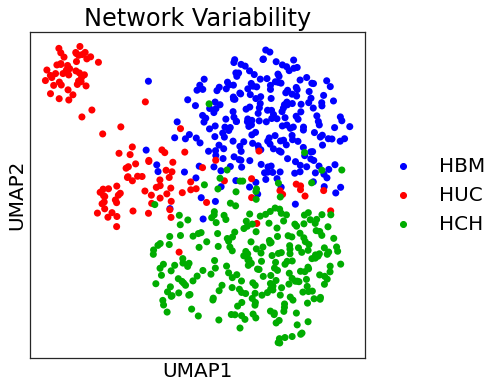

In [17]:
with rc_context({'figure.figsize': (6, 6), 'font.size': 20, 'axes.edgecolor': '0.15', 
                 'axes.linewidth': 1.25, 'axes.facecolor': '#FFFFFF', 'savefig.dpi': 600}):
    sc.pl.umap(var_adata, color=['cell_types'],
               legend_fontsize=20, legend_fontoutline=20, 
               frameon=True,  title='Network Variability')
               # , save=' BMES spatial network variability cell type.png')

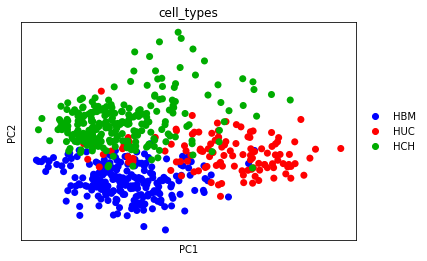

In [78]:
sc.pl.pca(var_adata, color=['cell_types'])

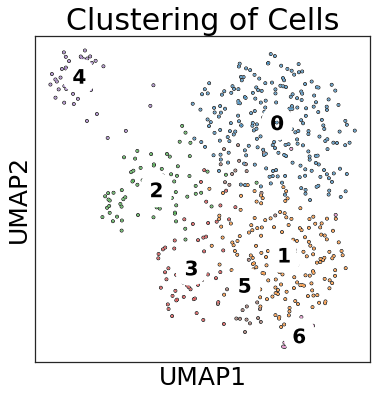

In [33]:
with rc_context({'figure.figsize': (6, 6), 'font.size':25, 'axes.edgecolor': '0.15', 'axes.linewidth': 1.25, 'axes.facecolor':'#FFFFFF'}):
    sc.pl.umap(var_adata, color=['leiden'], size=20,
               add_outline=True, legend_loc='on data',
               legend_fontsize=20, legend_fontoutline=20, 
               frameon=True,  title='Clustering of Cells', save=' network mean and variance clustering.png')

In [ ]:
with rc_context({'figure.figsize': (6, 6), 'font.size':25, 'axes.edgecolor': '0.15', 'axes.linewidth': 1.25, 'axes.facecolor':'#FFFFFF'}):
    sc.pl.heatmap(var_adata, color=['leiden'], size=20, groups=['4'],
               add_outline=True, legend_loc='on data',
               legend_fontsize=20, legend_fontoutline=20, 
               frameon=True,  title='clustering of cells', save=' network mean and variance clustering.png')

In [18]:
save_name = os.path.join('clustering of network variability 3 clusters.h5ad')
var_adata.write(filename=save_name)

In [19]:
var_sep_data = {'Cell ID': var_adata.obs['Cell'].tolist(),
                  'Cluster': var_adata.obs['leiden'].tolist(),
                  'Cell types': var_adata.obs['cell_types'].tolist()
                 }
var_set_data = pd.DataFrame(var_sep_data)
# var_adata

In [20]:
with open('.\\network variance 3 clustering v. cell type.pkl', 'wb') as f:
    pickle.dump(var_sep_data, f)

### Edge type plotting

In [13]:
edge_cell_id = pd.read_csv(r'.\\cytokine_figures\\edge_secretors.csv')
edge_cell_id

,IL8,CCL11,Both
0,exp1_bm_030_2,exp1_bm_007_1,exp1_bm_005_4
1,exp1_bm_057_1,exp1_bm_013_1,exp1_bm_008_1
2,exp1_uc_011_2,exp1_bm_021_3,exp1_bm_025_3
3,NaN,exp1_bm_022_1,exp1_bm_032_1
4,NaN,exp1_bm_042_2,exp1_bm_036_1
5,NaN,exp1_bm_074_1,exp1_bm_036_2
6,NaN,exp1_bm_091_3,exp1_bm_072_1
7,NaN,exp1_uc_012_1,exp1_uc_001_1
8,NaN,exp1_uc_013_1,exp1_uc_003_2
9,NaN,exp1_uc_016_1,exp1_uc_008_1


In [15]:
edge_cells = edge_cell_id['IL8'].tolist() + edge_cell_id['CCL11'].tolist() + edge_cell_id['Both'].tolist()
edge_indicator = []
for cell in var_adata.obs['Cell'].tolist():
    if cell in edge_cells:
        edge_indicator.append('Edge')
    else:
        edge_indicator.append('Non-edge')

In [16]:
edge_types = pd.Categorical(edge_indicator, ordered=True, categories=['Edge','Non-edge'])
var_adata.obs['edge_types'] = edge_types
var_adata.uns['edge_types_colors'] = ['#ee8f9c', '#729ed7']

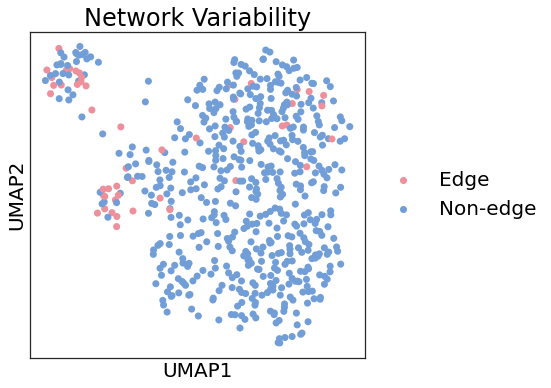

In [36]:
with rc_context({'figure.figsize': (6, 6), 'font.size': 20, 'axes.edgecolor': '0.15', 'axes.linewidth': 1.25, 'axes.facecolor': '#FFFFFF'}):
    sc.pl.umap(var_adata, color=['edge_types'],
               legend_fontsize=20, legend_fontoutline=20, 
               frameon=True,  title='Network Variability', save='edge on network variability.png')

# Permutation analysis of gene neighborhood networks

In [38]:
import neighborhoodAnalysis as nha
import util

from joblib import Parallel, delayed

## bm_exp1

In [24]:
# bm_exp1
dots_dir = r'Y:\coskun-lab\Zhou\4_HCR\20210324_11gene\BM\registered images\detected_dots_positions_v2'
adata_dir = r'Y:\coskun-lab\Zhou\4_HCR\20210324_11gene\BM\registered images\subcellular_neighborhood'
out_dir = r'Y:\coskun-lab\Zhou\4_HCR\20210324_11gene\BM\registered images\cell_df'

In [25]:
dots_fn_l = os.listdir(dots_dir)
adata_fn_l = os.listdir(adata_dir)

In [30]:
for fn in adata_fn_l:
    adata = None
    if fn.endswith('.h5ad'):
        adata = anndata.read_h5ad(filename=os.path.join(adata_dir, fn))
        name = fn.split(' ')[0]
        cell = pd.read_pickle(os.path.join(dots_dir, name+'.pkl'))
    else:
        continue
    neighborhood = adata.obs['leiden'].tolist()
    neighborhood = [int(item) for item in neighborhood]
    new_dic = {}
    for k in cell.keys():
        df = pd.DataFrame(cell[k])
        if len(cell[k]) == 0:
            continue
        df.columns = ['row', 'column']
        df['cluster'] = neighborhood[:df.shape[0]]
        neighborhood = neighborhood[df.shape[0]:]
        new_dic[k] = df
    
    df = None
    for k in new_dic.keys():
        if df is None:
            t = new_dic[k]
            t['gene'] = [k]*t.shape[0]
            df = t
        else:
            t = new_dic[k]
            t['gene'] = [k]*t.shape[0]
            df = pd.concat([df, t])
    save_name = name + ' cell_df.pkl'
    with open(os.path.join(out_dir,save_name),'wb') as f:
        pickle.dump(df, f)

In [116]:
# Compute proximity score
cell_df_dir = r'Y:\coskun-lab\Zhou\4_HCR\20210324_11gene\BM\registered images\cell_df'
cell_fn = os.listdir(cell_df_dir)
cell_fn.sort()

In [118]:
out_dir = r'Y:\coskun-lab\Zhou\4_HCR\20210324_11gene\BM\registered images\subcellular_network_batch\proximity_score_2000permutation'
for fn in tqdm(cell_fn):
    cell = pd.read_pickle(os.path.join(cell_df_dir, fn))
    
    patch_l = np.unique(cell['cluster'].tolist())
    patch_l.sort()
    interaction_l = Parallel(n_jobs=8)(delayed(nha.permutation)(cell.loc[cell['cluster']==p], n_neighbors=10,
                                     row_name='row',col_name='column',
                                      marker_names='gene',n_permutation=2000) for p in patch_l)
    
    name = fn.split('.')[0]
    save_name = name + ' proximity_score.pkl'
    with open(os.path.join(out_dir, save_name), 'wb') as f:
        pickle.dump(interaction_l, f)

100%|██████████████████████████████████████████████████████████████████████████████| 237/237 [1:59:41<00:00, 30.30s/it]


## uc_exp1

In [43]:
# uc_exp1
dots_dir = r'Y:\coskun-lab\Zhou\4_HCR\20210324_11gene\UC\00_registered_images\detected_dots_positions'
adata_dir = r'Y:\coskun-lab\Zhou\4_HCR\20210324_11gene\UC\00_registered_images\subcellular_neighborhoods'
out_dir = r'Y:\coskun-lab\Zhou\4_HCR\20210324_11gene\UC\00_registered_images\cell_df'

In [44]:
dots_fn_l = os.listdir(dots_dir)
adata_fn_l = os.listdir(adata_dir)

In [45]:
for fn in adata_fn_l:
    adata = None
    if fn.endswith('.h5ad'):
        adata = anndata.read_h5ad(filename=os.path.join(adata_dir, fn))
        name = fn.split(' ')[0]
        cell = pd.read_pickle(os.path.join(dots_dir, name+'.pkl'))
    else:
        continue
    neighborhood = adata.obs['leiden'].tolist()
    neighborhood = [int(item) for item in neighborhood]
    new_dic = {}
    for k in cell.keys():
        df = pd.DataFrame(cell[k])
        if len(cell[k]) == 0:
            continue
        df.columns = ['row', 'column']
        df['cluster'] = neighborhood[:df.shape[0]]
        neighborhood = neighborhood[df.shape[0]:]
        new_dic[k] = df
    
    df = None
    for k in new_dic.keys():
        if df is None:
            t = new_dic[k]
            t['gene'] = [k]*t.shape[0]
            df = t
        else:
            t = new_dic[k]
            t['gene'] = [k]*t.shape[0]
            df = pd.concat([df, t])
    save_name = name + ' cell_df.pkl'
    with open(os.path.join(out_dir,save_name),'wb') as f:
        pickle.dump(df, f)

In [119]:
# Compute proximity score
cell_df_dir = r'Y:\coskun-lab\Zhou\4_HCR\20210324_11gene\UC\00_registered_images\cell_df'
cell_fn = os.listdir(cell_df_dir)
cell_fn.sort()

In [120]:
out_dir = r'Y:\coskun-lab\Zhou\4_HCR\20210324_11gene\UC\00_registered_images\subcellular_network_batch\proximity_score_2000permutation'
for fn in tqdm(cell_fn):
    cell = pd.read_pickle(os.path.join(cell_df_dir, fn))
    
    patch_l = np.unique(cell['cluster'].tolist())
    patch_l.sort()
    interaction_l = Parallel(n_jobs=8)(delayed(nha.permutation)(cell.loc[cell['cluster']==p], n_neighbors=10,
                                     row_name='row',col_name='column',
                                      marker_names='gene',n_permutation=1000) for p in patch_l)
    
    name = fn.split('.')[0]
    save_name = name + ' proximity_score.pkl'
    with open(os.path.join(out_dir, save_name), 'wb') as f:
        pickle.dump(interaction_l, f)

100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [20:45<00:00, 15.38s/it]


## uc_exp2

In [50]:
# uc_exp2
dots_dir = r'Y:\coskun-lab\Zhou\4_HCR\20210507_cytokines\uc\00_registered_images\detected_dot_positions'
adata_dir = r'Y:\coskun-lab\Zhou\4_HCR\20210507_cytokines\uc\subcellular_neirhborhood'
out_dir = r'Y:\coskun-lab\Zhou\4_HCR\20210507_cytokines\uc\cell_df'
dots_fn_l = os.listdir(dots_dir)
adata_fn_l = os.listdir(adata_dir)

In [51]:
for fn in adata_fn_l:
    adata = None
    if fn.endswith('.h5ad'):
        adata = anndata.read_h5ad(filename=os.path.join(adata_dir, fn))
        name = fn.split(' ')[0]
        cell = pd.read_pickle(os.path.join(dots_dir, name+'.pkl'))
    else:
        continue
    neighborhood = adata.obs['leiden'].tolist()
    neighborhood = [int(item) for item in neighborhood]
    new_dic = {}
    for k in cell.keys():
        df = pd.DataFrame(cell[k])
        if len(cell[k]) == 0:
            continue
        df.columns = ['row', 'column']
        df['cluster'] = neighborhood[:df.shape[0]]
        neighborhood = neighborhood[df.shape[0]:]
        new_dic[k] = df
    
    df = None
    for k in new_dic.keys():
        if df is None:
            t = new_dic[k]
            t['gene'] = [k]*t.shape[0]
            df = t
        else:
            t = new_dic[k]
            t['gene'] = [k]*t.shape[0]
            df = pd.concat([df, t])
    save_name = name + ' cell_df.pkl'
    with open(os.path.join(out_dir,save_name),'wb') as f:
        pickle.dump(df, f)

In [121]:
# Compute proximity score
cell_df_dir = r'Y:\coskun-lab\Zhou\4_HCR\20210507_cytokines\uc\cell_df'
cell_fn = os.listdir(cell_df_dir)
cell_fn.sort()

In [122]:
out_dir = r'Y:\coskun-lab\Zhou\4_HCR\20210507_cytokines\uc\subcellular_network_batch\proximity_score_2000permutation'
for fn in tqdm(cell_fn):
    cell = pd.read_pickle(os.path.join(cell_df_dir, fn))
    
    patch_l = np.unique(cell['cluster'].tolist())
    patch_l.sort()
    interaction_l = Parallel(n_jobs=8)(delayed(nha.permutation)(cell.loc[cell['cluster']==p], n_neighbors=10,
                                     row_name='row',col_name='column',
                                      marker_names='gene',n_permutation=1000) for p in patch_l)
    
    name = fn.split('.')[0]
    save_name = name + ' proximity_score.pkl'
    with open(os.path.join(out_dir, save_name), 'wb') as f:
        pickle.dump(interaction_l, f)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [09:35<00:00, 14.39s/it]


## hch

In [54]:
# hch
dots_dir = r'Y:\coskun-lab\Zhou\4_HCR\20210614_hchCulture\00_registered_images\detected_dots'
adata_dir = r'Y:\coskun-lab\Zhou\4_HCR\20210614_hchCulture\subcellular_neighborhoods'
out_dir = r'Y:\coskun-lab\Zhou\4_HCR\20210614_hchCulture\cell_df'
dots_fn_l = os.listdir(dots_dir)
adata_fn_l = os.listdir(adata_dir)

In [55]:
for fn in adata_fn_l:
    adata = None
    if fn.endswith('.h5ad'):
        adata = anndata.read_h5ad(filename=os.path.join(adata_dir, fn))
        name = fn.split(' ')[0]
        cell = pd.read_pickle(os.path.join(dots_dir, name+'.pkl'))
    else:
        continue
    neighborhood = adata.obs['leiden'].tolist()
    neighborhood = [int(item) for item in neighborhood]
    new_dic = {}
    for k in cell.keys():
        df = pd.DataFrame(cell[k])
        if len(cell[k]) == 0:
            continue
        df.columns = ['row', 'column']
        df['cluster'] = neighborhood[:df.shape[0]]
        neighborhood = neighborhood[df.shape[0]:]
        new_dic[k] = df
    
    df = None
    for k in new_dic.keys():
        if df is None:
            t = new_dic[k]
            t['gene'] = [k]*t.shape[0]
            df = t
        else:
            t = new_dic[k]
            t['gene'] = [k]*t.shape[0]
            df = pd.concat([df, t])
    save_name = name + ' cell_df.pkl'
    with open(os.path.join(out_dir,save_name),'wb') as f:
        pickle.dump(df, f)

In [123]:
# Compute proximity score
cell_df_dir = r'Y:\coskun-lab\Zhou\4_HCR\20210614_hchCulture\cell_df'
cell_fn = os.listdir(cell_df_dir)
cell_fn.sort()

In [124]:
out_dir = r'Y:\coskun-lab\Zhou\4_HCR\20210614_hchCulture\subcellular_network_batch\proximity_score_2000permutation'
for fn in tqdm(cell_fn):
    cell = pd.read_pickle(os.path.join(cell_df_dir, fn))
    
    patch_l = np.unique(cell['cluster'].tolist())
    patch_l.sort()
    interaction_l = Parallel(n_jobs=8)(delayed(nha.permutation)(cell.loc[cell['cluster']==p], n_neighbors=10,
                                     row_name='row',col_name='column',
                                      marker_names='gene',n_permutation=1000) for p in patch_l)
    
    name = fn.split('.')[0]
    save_name = name + ' proximity_score.pkl'
    with open(os.path.join(out_dir, save_name), 'wb') as f:
        pickle.dump(interaction_l, f)

100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [51:46<00:00, 12.58s/it]


# Network variability

## bm

In [126]:
cell = pd.read_pickle(r'Y:\coskun-lab\Zhou\4_HCR\20210324_11gene\BM\registered images\cell_df\exp1_bm_001_1 cell_df.pkl')

In [127]:
cell['gene'].unique()

array(['GAPDH', 'ACTB', 'IL8', 'IL6', 'CCL11', 'COL1A1', 'NANOG', 'SOX9',
       'EEF2', 'SPP1', 'RUNX1', 'PDL1'], dtype=object)

In [128]:
markers = np.unique(cell['gene'])
pairs = []
for i in range(len(markers)):
    for j in range(len(markers)):
        if not ((markers[i]+'_'+markers[j] in pairs) or (markers[j]+'_'+markers[i] in pairs)):
            pairs.append(markers[i]+'_'+markers[j])

In [129]:
in_dir = r'Y:\coskun-lab\Zhou\4_HCR\20210324_11gene\BM\registered images\subcellular_network_batch\proximity_score_2000permutation'
fn_l = os.listdir(in_dir)
var_names = []
arr = []
bm_cell_ids = []
for fn in tqdm(fn_l):
    bm_cell_ids.append(fn.split(' ')[0])
    l = pd.read_pickle(os.path.join(in_dir, fn))
    temp = []
    m = np.zeros(len(pairs))
    s = np.zeros(len(pairs))
    for j in range(len(pairs)):
        gene1,gene2 = pairs[j].split('_')
        temp.append([])
        for i in range(len(l)):
            if l[i] is None:
                continue
            if (gene1 in l[i][0].columns.tolist()) and (gene2 in l[i][0].columns.tolist()):
                temp[j].append(l[i][0].loc[gene1,gene2])
        if len(temp[j])!=0:
            m[j] = np.mean(np.array(temp[j]))
            s[j] = np.std(np.array(temp[j]))
    arr.append(np.concatenate((m,s)))

100%|████████████████████████████████████████████████████████████████████████████████| 237/237 [00:12<00:00, 19.16it/s]


In [130]:
arr = np.array(arr)
var_names = []
for p in pairs:
    var_names.append(p+'_mean')
    var_names.append(p+'_std')
bm_df = pd.DataFrame(arr, columns=var_names)

## uc_exp1

In [131]:
in_dir = r'Y:\coskun-lab\Zhou\4_HCR\20210324_11gene\UC\00_registered_images\subcellular_network_batch\proximity_score_2000permutation'
fn_l = os.listdir(in_dir)
var_names = []
arr = []
uc1_cell_ids = []
for fn in tqdm(fn_l):
    uc1_cell_ids.append(fn.split(' ')[0])
    l = pd.read_pickle(os.path.join(in_dir, fn))
    temp = []
    m = np.zeros(len(pairs))
    s = np.zeros(len(pairs))
    for j in range(len(pairs)):
        gene1,gene2 = pairs[j].split('_')
        temp.append([])
        for i in range(len(l)):
            if l[i] is None:
                continue
            if (gene1 in l[i][0].columns.tolist()) and (gene2 in l[i][0].columns.tolist()):
                temp[j].append(l[i][0].loc[gene1,gene2])
        if len(temp[j])!=0:
            m[j] = np.mean(np.array(temp[j]))
            s[j] = np.std(np.array(temp[j]))
    arr.append(np.concatenate((m,s)))

100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [00:04<00:00, 18.79it/s]


In [132]:
arr = np.array(arr)
var_names = []
for p in pairs:
    var_names.append(p+'_mean')
    var_names.append(p+'_std')
uc1_df = pd.DataFrame(arr, columns=var_names)

## uc_exp2

In [133]:
in_dir = r'Y:\coskun-lab\Zhou\4_HCR\20210507_cytokines\uc\subcellular_network_batch\proximity_score_2000permutation'
fn_l = os.listdir(in_dir)
var_names = []
arr = []
uc2_cell_ids = []
for fn in tqdm(fn_l):
    uc2_cell_ids.append(fn.split(' ')[0])
    l = pd.read_pickle(os.path.join(in_dir, fn))
    temp = []
    m = np.zeros(len(pairs))
    s = np.zeros(len(pairs))
    for j in range(len(pairs)):
        gene1,gene2 = pairs[j].split('_')
        temp.append([])
        for i in range(len(l)):
            if l[i] is None:
                continue
            if (gene1 in l[i][0].columns.tolist()) and (gene2 in l[i][0].columns.tolist()):
                temp[j].append(l[i][0].loc[gene1,gene2])
        if len(temp[j])!=0:
            m[j] = np.mean(np.array(temp[j]))
            s[j] = np.std(np.array(temp[j]))
    arr.append(np.concatenate((m,s)))

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.53it/s]


In [134]:
arr = np.array(arr)
var_names = []
for p in pairs:
    var_names.append(p+'_mean')
    var_names.append(p+'_std')
uc2_df = pd.DataFrame(arr, columns=var_names)

## hch

In [135]:
in_dir = r'Y:\coskun-lab\Zhou\4_HCR\20210614_hchCulture\subcellular_network_batch\proximity_score_2000permutation'
fn_l = os.listdir(in_dir)
var_names = []
arr = []
hch_cell_ids = []
for fn in tqdm(fn_l):
    hch_cell_ids.append(fn.split(' ')[0])
    l = pd.read_pickle(os.path.join(in_dir, fn))
    temp = []
    m = np.zeros(len(pairs))
    s = np.zeros(len(pairs))
    for j in range(len(pairs)):
        gene1,gene2 = pairs[j].split('_')
        temp.append([])
        for i in range(len(l)):
            if l[i] is None:
                continue
            if (gene1 in l[i][0].columns.tolist()) and (gene2 in l[i][0].columns.tolist()):
                temp[j].append(l[i][0].loc[gene1,gene2])
        if len(temp[j])!=0:
            m[j] = np.mean(np.array(temp[j]))
            s[j] = np.std(np.array(temp[j]))
    arr.append(np.concatenate((m,s)))

100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:11<00:00, 22.07it/s]


In [136]:
arr = np.array(arr)
var_names = []
for p in pairs:
    var_names.append(p+'_mean')
    var_names.append(p+'_std')
hch_df = pd.DataFrame(arr, columns=var_names)

## Combine and cluster

In [137]:
combined_df = pd.concat([bm_df, uc1_df, uc2_df, hch_df], join='inner')
var_names = combined_df.columns.tolist()
cell_types = ['HBM']*len(bm_cell_ids) + ['HUC']*(len(uc1_cell_ids)+len(uc2_cell_ids)) + ['HCH']*len(hch_cell_ids)

In [152]:
var_adata = sc.read_h5ad('patch correlation 1000 permutation.h5ad')

In [7]:
var_adata = sc.AnnData(combined_df.values)
var_adata.obs['Cell'] = bm_cell_ids+uc1_cell_ids+uc2_cell_ids+hch_cell_ids
var_adata.var_names = var_names
var_adata.obs['cell_types'] = cell_types
var_adata.uns['cell_types_colors'] = ['#0000ff', '#00ac00', '#ff0000']

In [154]:
sc.pp.pca(var_adata)
sc.pp.neighbors(var_adata)
sc.tl.umap(var_adata)
sc.tl.tsne(var_adata)
sc.tl.leiden(var_adata, resolution=1)

C:\Users\zfang38\Anaconda3\envs\scenv\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


In [6]:
var_adata = sc.read_h5ad(r'patch correlation 1000 permutation.h5ad')

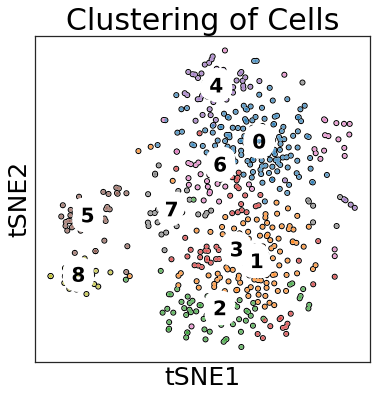

In [4]:
with rc_context({'figure.figsize': (6, 6), 'font.size':25, 'axes.edgecolor': '0.15', 'axes.linewidth': 1.25, 'axes.facecolor':'#FFFFFF'}):
    sc.pl.tsne(var_adata, color=['leiden'], size=50,
               add_outline=True, legend_loc='on data',
               legend_fontsize=20, legend_fontoutline=20, 
               frameon=True,  title='Clustering of Cells',
               save=' msc 1000 permutation networks clustering.png')

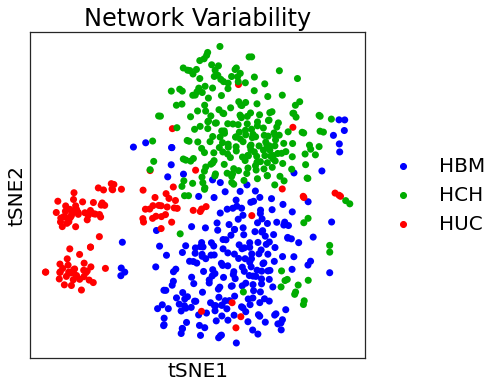

In [10]:
with rc_context({'figure.figsize': (6, 6), 'font.size': 20, 'axes.edgecolor': '0.15', 
                 'axes.linewidth': 1.25, 'axes.facecolor': '#FFFFFF', 'savefig.dpi': 600}):
    sc.pl.tsne(var_adata, color=['cell_types'],
               legend_fontsize=20, legend_fontoutline=20, 
               frameon=True,  title='Network Variability',
               save=' msc 1000 permutation networks cell types.png')

In [157]:
var_adata

AnnData object with n_obs × n_vars = 605 × 156
    obs: 'Cell', 'cell_types', 'leiden'
    uns: 'cell_types_colors', 'pca', 'neighbors', 'umap', 'tsne', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [158]:
data = {'Cell types':var_adata.obs['cell_types'].tolist(), 'Cluster':var_adata.obs['leiden'].tolist()}
with open(r'..\seqfish_results\v2_permutation_networks\network variance clustering v. cell type.pkl', 'wb') as f:
    pickle.dump(data, f)

In [159]:
var_adata.write(r'patch correlation 1000 permutation.h5ad')